In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from keras.constraints import maxnorm
from keras.layers import Dropout
from tensorflow.keras.utils import plot_model
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = '/content/drive/MyDrive/final_tidy_reddits_lemmetized.json'
df = pd.read_json(path, orient='table')

In [ ]:
df.shape

(301746, 4)

In [ ]:
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

In [ ]:
df.sample(7)

,label,text,lemmatized,tokens_back_to_text
129582,depression,"[hi, guys, maybe, help, think, depressed, life, never, thought, depression, cause, always, thought, feelings, normal, pretty, sure, used, cry, every, single, day, every, little, thing, would, make, cry, fourth, grade, still, know, like, extremely, sensitive, never, cared, school, made, never, homework, pretty, much, life, care, could, drive, social, anxiety, think, started, parents, telling, useless, would, never, amount, anything, never, thought, suicide, always, negative, thoughts, everything, never, remember, ever, happy, im, kind, still, like, except, way, less, severe, anyone, experienced, things, thank, advance, think, depressed, since, child]","[hi, guy, maybe, help, think, depressed, life, never, thought, depression, cause, always, thought, feeling, normal, pretty, sure, use, cry, every, single, day, every, little, thing, would, make, cry, fourth, grade, still, know, like, extremely, sensitive, never, care, school, make, never, homework, pretty, much, life, care, could, drive, social, anxiety, think, start, parent, tell, useless, would, never, amount, anything, never, thought, suicide, always, negative, thought, everything, never, remember, ever, happy, im, kind, still, like, except, way, less, severe, anyone, experienced, thing, thank, advance, think, depressed, since, child]",hi guy maybe help think depressed life never thought depression cause always thought feeling normal pretty sure use cry every single day every little thing would make cry fourth grade still know like extremely sensitive never care school make never homework pretty much life care could drive social anxiety think start parent tell useless would never amount anything never thought suicide always negative thought everything never remember ever happy im kind still like except way less severe anyone experienced thing thank advance think depressed since child
199105,depression,"[miserable, life, envy, people, lives]","[miserable, life, envy, people, life]",miserable life envy people life
299657,depression,"[people, may, see, perfectly, normal, person, see, deformed, monster, see, matter, wear, body, fear, smell, im, hideous, expect, people, run, ive, treated, like, freak, nature, vultures, picked, away, flaws, im, disgusted, entirety, body, im, sure, society, become, critical, peoples, appearances, im, treated, like, never, made, cut, demons, treating, apart, anymore, years, self, confident, ive, made, feel, worthless, unlovable, unattractive, years, finding, difficult, function, society, im, constantly, shot, treat, like, im, shadow, ive, finally, fallen, rock, bottom, blazing, molten, core, get, home, everyday, scream, mirror, sit, silence, pass, exhaustion, repeat, day, going, long, im, longer, alive, im, zombie, shuffling, way, distorted, ...]","[people, may, see, perfectly, normal, person, see, deform, monster, see, matter, wear, body, fear, smell, im, hideous, expect, people, run, ive, treat, like, freak, nature, vulture, picked, away, flaw, im, disgust, entirety, body, im, sure, society, become, critical, people, appearance, im, treat, like, never, make, cut, demon, treat, apart, anymore, year, self, confident, ive, make, feel, worthless, unlovable, unattractive, year, find, difficult, function, society, im, constantly, shot, treat, like, im, shadow, ive, finally, fall, rock, bottom, blazing, molten, core, get, home, everyday, scream, mirror, sit, silence, pas, exhaustion, repeat, day, go, long, im, longer, alive, im, zombie, shuffle, way, distort, ...]",people may see perfectly normal person see deform monster see matter wear body fear smell im hideous expect people run ive treat like freak nature vulture picked away flaw im disgust entirety body im sure society become critical people appearance im treat like never make cut demon treat apart anymore year self confident ive make feel worthless unlovable unattractive year find difficult function society im constantly shot treat like im

In [ ]:
df.isna().sum()

label                  0
text                   0
lemmatized             0
tokens_back_to_text    0
dtype: int64

In [ ]:
reddits = list(df['tokens_back_to_text'])
type(reddits)

list

In [ ]:
len(reddits)

301746

In [ ]:
df['label'].value_counts()

depression    178453
Anxiety        84001
bipolar        39292
Name: label, dtype: int64

In [ ]:
df['label'] = np.where(df['label']=='depression',1,0)

In [ ]:
df.head(3)

,label,text,lemmatized,tokens_back_to_text
0,0,"[struggled, social, anxiety, childhood, main, advice, friends, books, professionals, expose, environments, better, example, get, anxious, every, single, time, go, shop, even, though, shopping, weekly, since, get, nervous, sweaty, heart, pounding, every, time, go, gym, yet, working, gym, years, exposure, worked, anyone, else, exposure, work]","[struggle, social, anxiety, childhood, main, advice, friend, book, professional, expose, environment, well, example, get, anxious, every, single, time, go, shop, even, though, shopping, weekly, since, get, nervous, sweaty, heart, pound, every, time, go, gym, yet, work, gym, year, exposure, work, anyone, else, exposure, work]",struggle social anxiety childhood main advice friend book professional expose environment well example get anxious every single time go shop even though shopping weekly since get nervous sweaty heart pound every time go gym yet work gym year exposure work anyone else exposure work
1,0,"[back, march, know, ago, woke, day, go, school, feeling, kind, felt, depressed, really, feel, like, getting, even, seeing, anyone, history, p, really, mainly, happens, winter, time, get, highly, anxious, also, going, anywhere, periods, time, get, suspicious, paranoid, everyone, anything, usually, end, isolating, room, eat, way, less, also, get, highly, irritable, emotional, like, one, time, mom, sent, store, milk, started, crying, store, thought, going, killed, watched, believe, periods, government, something, higher, power, gerbil, studies, something, like, thought, news, real, used, put, fear, people, also, sort, figures, imagination, trying, manipulate, usually, happens, anywhere, day, weekish, also, insomniac, means, anything, p, anyways, yes, ...]","[back, march, know, ago, woke, day, go, school, feel, kind, felt, depressed, really, feel, like, get, even, see, anyone, history, p, really, mainly, happens, winter, time, get, highly, anxious, also, go, anywhere, period, time, get, suspicious, paranoid, everyone, anything, usually, end, isolate, room, eat, way, less, also, get, highly, irritable, emotional, like, one, time, mom, sent, store, milk, start, cry, store, thought, go, kill, watch, believe, period, government, something, high, power, gerbil, study, something, like, thought, news, real, use, put, fear, people, also, sort, figure, imagination, try, manipulate, usually, happens, anywhere, day, weekish, also, insomniac, mean, anything, p, anyways, yes, ...]",back march know ago woke day go school feel kind felt depressed really feel like get even see anyone history p really mainly happens winter time get highly anxious also go anywhere period time get suspicious paranoid everyone anything usually end isolate room eat way less also get highly irritable emotional like one time mom sent store milk start cry store thought go kill watch believe period government something high power gerbil study something like thought news real use put fear people also sort figure imagination try manipulate usually happens anywhere day weekish also insomniac mean anything p anyways yes thats background sit class feel highly anxious everything everyone guess get break point math class second block talk friend remember lot bit blurry happen explain real knew everything figure plan subject everything told thing life matter go die might die right extremely loud talk confuse unaware behaving teacher sat back class like nothing happen kid kind confuse kind explain understand alive point die one remember u really odd recap event suicidal really character end skip rest afternoon day friend request go home sleep bit talk friend happen tell scar go kill confuse despite talk loud much emotion besides try talk parent talk mom feeling nothing real say kid feel like time discus amongst friend ca relate couple month later mom take family doctor ask question kept say everyone felt really awkward find insomniac try go doctor grandma month two ask say felt paranoid somet

In [ ]:
df['label'].value_counts()

1    178453
0    123293
Name: label, dtype: int64

## **Feature extraction**

In [ ]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reddits)

In [ ]:
word_index = tokenizer.word_index
print('WE HAVE %s UNIQUE TOKENS.' % len(word_index))

WE HAVE 95809 UNIQUE TOKENS.


In [ ]:
sequences = tokenizer.texts_to_sequences(reddits)

In [ ]:
# pad redddits to a max length of 150 words
maxlen = 150
X = pad_sequences(sequences, maxlen = maxlen)
X.shape

(301746, 150)

In [ ]:
y = df['label']

##Split the dataset into **training** and **test** sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((241396, 150), (60350, 150), (241396,), (60350,))

In [ ]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

# Defining the **Convolutional Neural Network Model**

In [ ]:
# Prepare hyperparameters of CNN
vocab_size = len(word_index) + 1
# output_dim = 32

In [ ]:
# Building the CNN Model
model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=maxlen))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())

model.add(Dense(250, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

### Visualizing the CNN Model

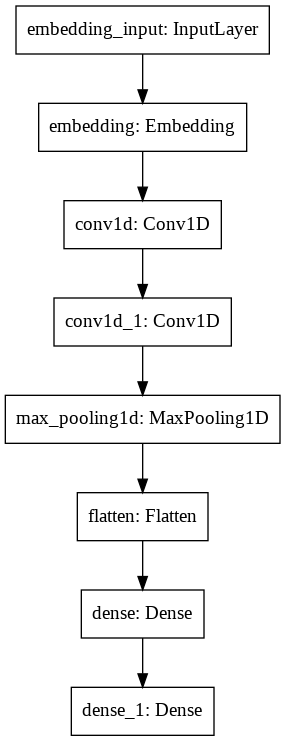

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          12263680  
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 128)          49280     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 64)           24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               1200250   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

### Using the **Adam optimizer** for the optimization and **Binary cross entropy** to calculate the Loss Function

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
start = time.time()

# fit the model to the training set
cnn_hist = model.fit(X_train, y_train, epochs = 5, validation_split = 0.2)

# evaluation of the model on the test set
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start) // 60
print('Training duration : {} minutes'.format(total))

Epoch 1/5
6035/6035 [==============================] - 1187s 197ms/step - loss: 0.3080 - accuracy: 0.8744 - val_loss: 0.2852 - val_accuracy: 0.8846
Epoch 2/5
6035/6035 [==============================] - 1184s 196ms/step - loss: 0.2600 - accuracy: 0.8976 - val_loss: 0.2843 - val_accuracy: 0.8866
Epoch 3/5
6035/6035 [==============================] - 1188s 197ms/step - loss: 0.2210 - accuracy: 0.9143 - val_loss: 0.3104 - val_accuracy: 0.8783
Epoch 4/5
6035/6035 [==============================] - 1187s 197ms/step - loss: 0.1758 - accuracy: 0.9333 - val_loss: 0.3427 - val_accuracy: 0.8748
Epoch 5/5
6035/6035 [==============================] - 1193s 198ms/step - loss: 0.1310 - accuracy: 0.9507 - val_loss: 0.4454 - val_accuracy: 0.8640
Accuracy: 86.51%
Training duration : 99.0 minutes


In [ ]:
history_dict = cnn_hist.history

## **Plotting the loss and the accuracy of both training and validation sets using the model history**

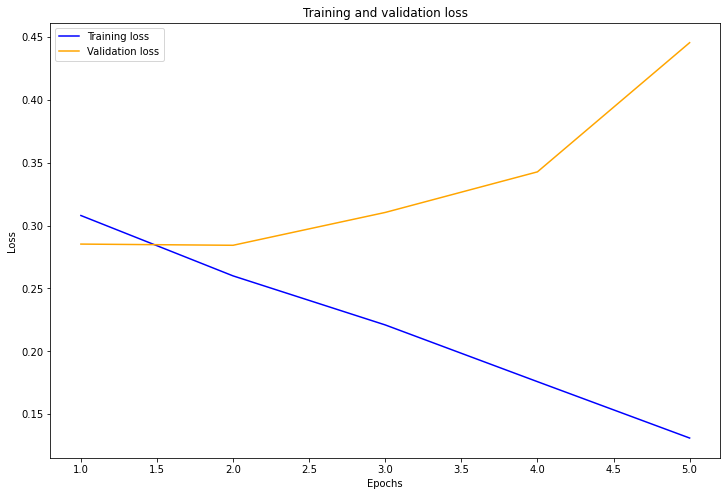

In [ ]:
# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1) 

# plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss_values, 'blue',label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

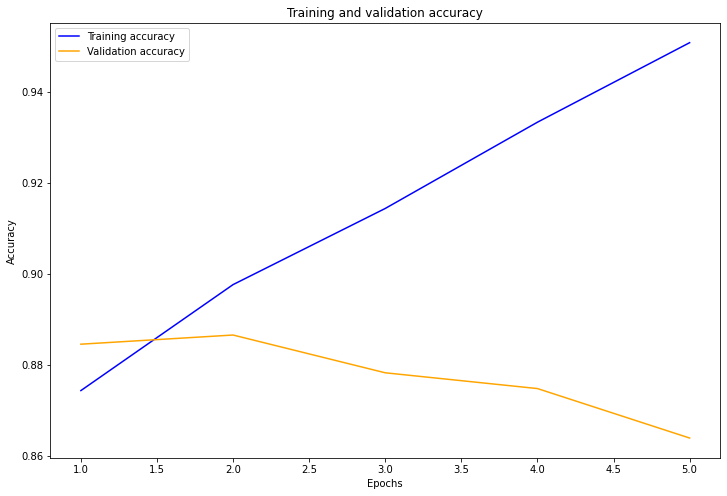

In [ ]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'blue',label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Confusion matrix**

In [ ]:
preds = np.round(model.predict(X_test),0)

In [ ]:
cm = confusion_matrix(y_test, preds)

In [ ]:
df_cm = pd.DataFrame(cm, index = ["depression", "non-depression"], columns = ["depression", "non-depression"])

Text(30.499999999999993, 0.5, 'Predicted Class')

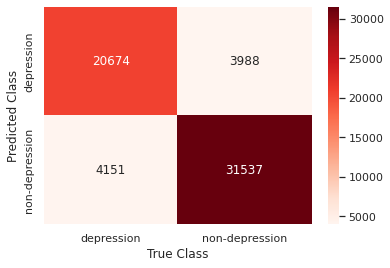

In [ ]:
plt.figure(figsize=(6, 4))
sb.heatmap(df_cm, annot=True, cmap="Reds", fmt='d')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')